In [1]:
import numpy as np
import math
import pickle
import os
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

from termcolor import colored
import pandas as pd

# What is convolution?

$$ 
(f * g)(t) = \int_{-\infty}^{\infty} f(\tau) g(t - \tau) \, d\tau
$$

# suppose we have 2 functions

In [2]:
def function_f(t):
    return math.sin(t - 5) 

def function_g(t):
    return math.sin(t)

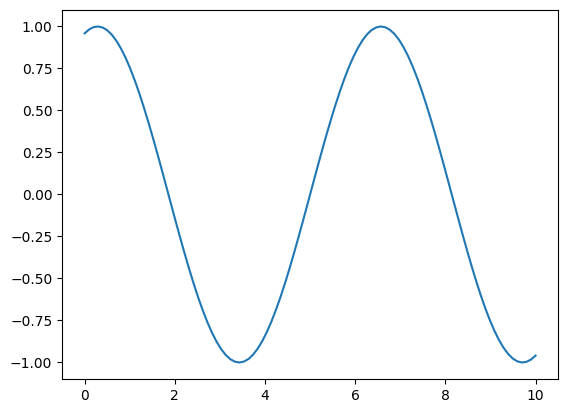

In [3]:
time = np.linspace(0, 10, 100)

fn_f_on_time = [function_f(t) for t in time]

plt.plot(time, fn_f_on_time)

In [4]:
tau = 0
integral_mult_results = []


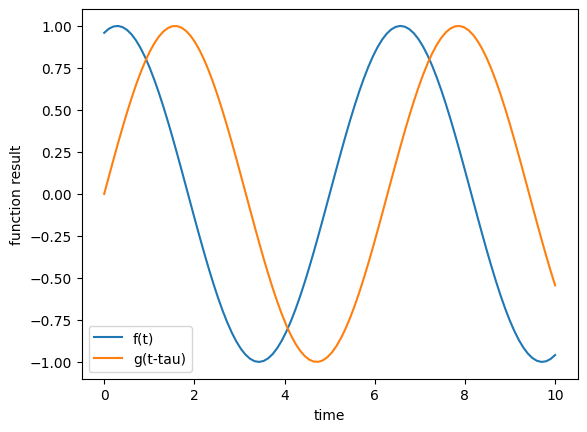

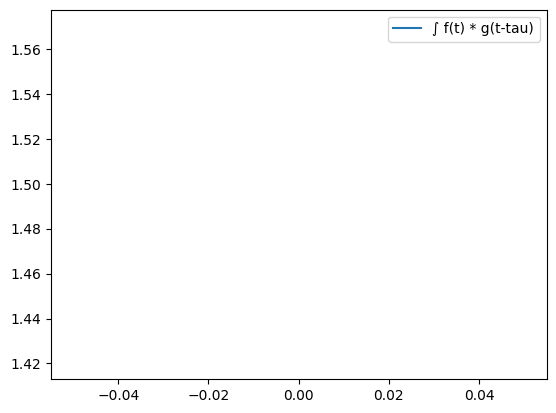

In [5]:
fn_g_on_time_shifted = [function_g(t - tau) for t in time]

plt.plot(time, fn_f_on_time, label="f(t)")
plt.xlabel("time")
plt.ylabel("function result")
plt.plot(time, fn_g_on_time_shifted, label="g(t-tau)")

plt.legend()
plt.show()


int_f_mult_g = np.trapz(np.array(fn_f_on_time) * np.array(fn_g_on_time_shifted), time)
integral_mult_results.append(int_f_mult_g)

plt.plot(integral_mult_results, label="∫ f(t) * g(t-tau)")
plt.legend()


tau += 1

# Introduction

In [6]:
# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

partition = 1
train_images = train_images[:int(len(train_images) * partition)]
train_labels = train_labels[:int(len(train_labels) * partition)]

# # Preprocess the data
train_images = train_images / 255.0
test_images = test_images / 255.0
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)


test_images.shape, train_images.shape

((10000, 28, 28), (60000, 28, 28))

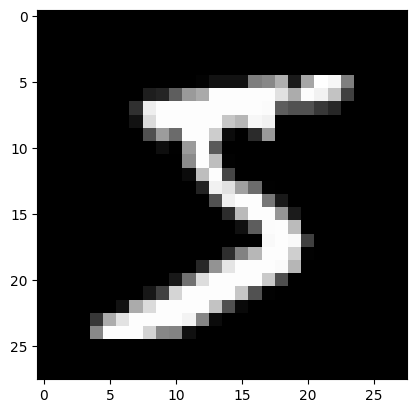

In [7]:
img_0 = train_images[0]
plt.imshow(img_0, cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5898398817060565..0.719338105023532].


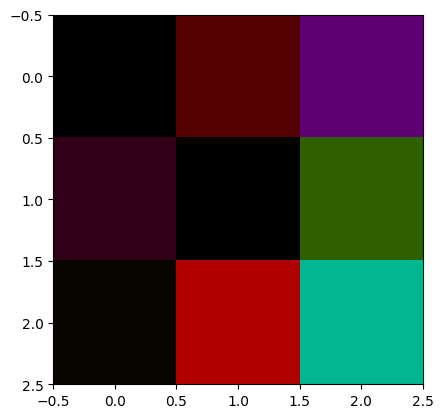

In [8]:
def get_filter(size, c=1):
    h, w = size
    return np.random.randn(h, w, c) / math.sqrt(h * w)

rand_filter = get_filter((3, 3), 3)
plt.imshow(rand_filter)

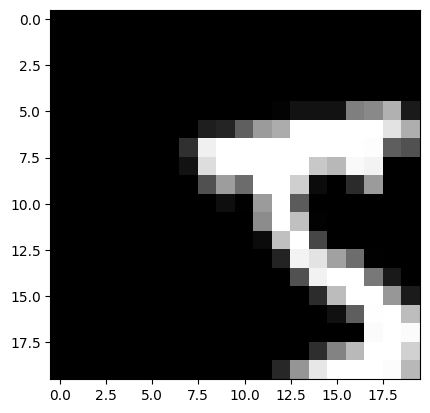

In [9]:
row = 0
col = 0
w = 20
h = 20

plt.imshow(
    img_0[row:row + h, col:col + w],
    cmap='gray'
)

In [10]:
def map_matrix(image, fn, size, stride):
    size_w, size_h = size

    new_image = []

    max_i = len(image) - size_w + 1
    max_j = len(image[0]) - size_h + 1
    range_i = range(0, max_i, stride)
    range_j = range(0, max_j, stride)

    max_column_count = len(range_j) 

    indexes = {
        'slice_flat_index': 0,
        'slice_i': 0,
        'slice_j': 0,
    }

    for i in range_i:
        new_image.append([])  
        for j in range_j:
            sub_matrix = image[i:i + size_w, j:j + size_h]
       
            slice_i = i // stride
            slice_j = j // stride

            indexes['slice_i'] = slice_i
            indexes['slice_j'] = slice_j
            indexes['slice_flat_index'] =  slice_j + slice_i * max_column_count

            new_image[-1].append(fn(sub_matrix, indexes))  

    return new_image


def foreach_matrix(image, fn, size, stride):
    size_w, size_h = size

    max_i = len(image) - size_w + 1
    max_j = len(image[0]) - size_h + 1
    range_i = range(0, max_i, stride)
    range_j = range(0, max_j, stride)

    max_column_count = len(range_j)

    indexes = {
        'slice_flat_index': 0,
        'slice_i': 0,
        'slice_j': 0,
    }

    for i in range_i:
        for j in range_j:
            sub_matrix = image[i:i + size_w, j:j + size_h]
       
            slice_i = i // stride
            slice_j = j // stride

            indexes['slice_i'] = slice_i
            indexes['slice_j'] = slice_j
            indexes['slice_flat_index'] =  slice_j + slice_i * max_column_count

            fn(sub_matrix, indexes, image)



In [11]:
def print_fn(sub_matrix, metadata, image):
    print(f"Sub-matrix at {metadata}:")
    for row in sub_matrix:
        print(row)
    print()

# Example input
image = np.array([
    [1, 2, 3, 4],
    [5, 6, 7, 8],
    [9, 10, 11, 12],
    [13, 14, 15, 16]
])

size = (2, 2)  # Sub-matrix size: 2x2
stride = 2     # Stride: step size of 2

# Call foreach_matrix
foreach_matrix(image, print_fn, size, stride)

Sub-matrix at {'slice_flat_index': 0, 'slice_i': 0, 'slice_j': 0}:
[1 2]
[5 6]

Sub-matrix at {'slice_flat_index': 1, 'slice_i': 0, 'slice_j': 1}:
[3 4]
[7 8]

Sub-matrix at {'slice_flat_index': 2, 'slice_i': 1, 'slice_j': 0}:
[ 9 10]
[13 14]

Sub-matrix at {'slice_flat_index': 3, 'slice_i': 1, 'slice_j': 1}:
[11 12]
[15 16]



(13, 13)

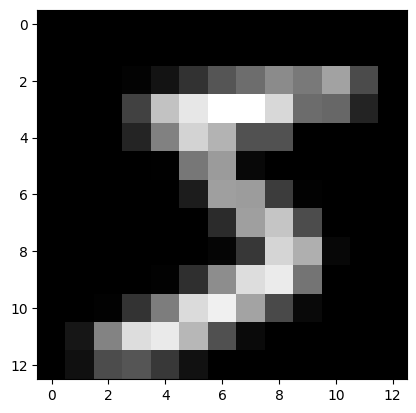

In [12]:
filter_size = (3, 3)
stride = 2
img_conv_example = map_matrix(
    img_0,
    lambda x, _: np.sum(x), 
    size=filter_size, 
    stride = stride,
)

plt.imshow(img_conv_example, cmap='gray')
np.array(img_conv_example).shape

# 1 Layer

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..6.589269440644697].


(3, 5, 5, 1) filters shape


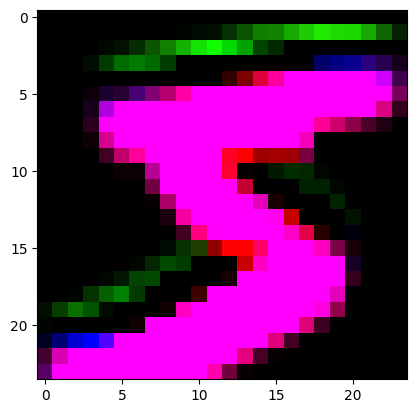

In [13]:
filter_size = (5, 5)
stride = 1

filter_size2 = 5
stride2 = 1

pool_0_size = 2
pool_0_stride = 2   

filters = np.array([get_filter(filter_size) for _ in range(3)])
biases = np.array([0, 0, 0])

print(filters.shape, 'filters shape')


def relu(x):
    return np.maximum(0, x)

def cross_cor(x):
    result = []

    for i in range(len(filters)):
        result.append(
            relu(np.sum(x * filters[i]) + biases[i])
        )

    return result

# convolution filter 1
output_img_0 = map_matrix(
    img_0,
    lambda x, _: cross_cor(x), 
    filter_size, 
    stride,
)

# 28x28 -> 10x10

np.array(output_img_0).shape

plt.imshow(output_img_0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.246951995635475..3.194695040876105].


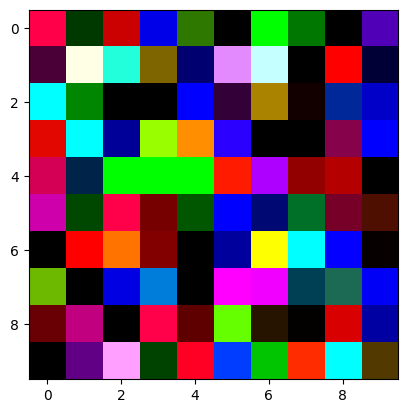

In [14]:
# random matrix
rand_img = np.random.randn(10, 10, 3)
plt.imshow(rand_img)

(4.245621743955879,
 [4.245621743955879,
  5.071240307499947,
  1.399939010400196,
  -3.4901167238329793,
  -1.575544551050918,
  5.85408861361203,
  1.354485947495742,
  -5.26863805280347,
  -3.862873773835044],
 (2, 2, 3))

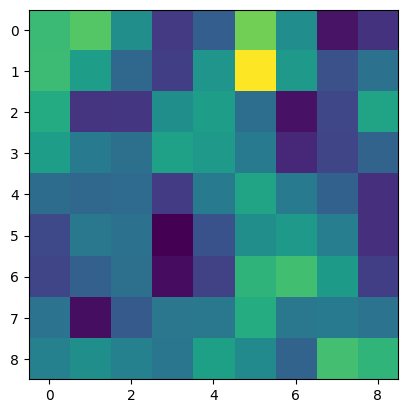

In [15]:
sum_relu = map_matrix(
    rand_img,
    lambda x, _: np.sum(x), 
    (2, 2),
    1,
)

plt.imshow(sum_relu)

first_lamda_call = rand_img[0:2, 0:2]

np.sum(first_lamda_call), sum_relu[0], first_lamda_call.shape

In [16]:
class LayerConv2D:
    @staticmethod
    def relu(x):
        return np.maximum(0, x)

    @staticmethod
    def sigmoid(x):
        x = np.clip(x, -500, 500)
                
        return 1 / (1 + np.exp(-x))

    def df_activation(self):
        """
            activated_output -> aL = σ(zL)
        """
        # activated_output = np.clip(activated_output, -500, 500)
        activated_output = self.output
        
        if self.activation == LayerConv2D.sigmoid:
            return activated_output * (1 - activated_output)
        elif self.activation == LayerConv2D.relu:
            return np.where(activated_output <= 0, 0, 1)

    def init_filters(self):
        w, h = self.filter_dim
        
        self.weights = np.random.randn(
            self.filters_count, 
            w, 
            h, 
            self.channels
        ) / math.sqrt(h * w)

    def init_biases(self):
        self.biases = np.zeros(self.filters_count)

    def set_channels(self, images):
        self.channels = images.shape[-1]
    
    def __init__(self, filters_count, filter_dim, stride=1, channels=None, activation=relu):
        self.filters_count = filters_count
        self.filter_dim = filter_dim
        self.stride = stride

        self.activation = activation
        self.channels = channels

        if (self.channels is not None):
            self.init_filters()

        self.init_biases()

    def cross_cor(self, x, _):
        # x -> [x, y, channels]
        result = []

        for i in range(len(self.weights)):
            result.append(
                self.activation(
                    np.sum(x * self.weights[i]) + self.biases[i]
                )
            )

        return result


    def forward(self, images):
        '''
           [ image, width, height, inputChannels ]
           # for input channel is equal to the number of colors (3 for RGB) or the number of filters from the previous layer
           # for the output channel is equal to the number of filters

           return [ image, width, height, outputChannels ]
        '''

        if (self.channels is None):
            self.set_channels(images)
            self.init_filters()

        self.output = []

        for image, image_idx in zip(images, range(len(images))):
            # ... width, height, channels ]
            self.output.append(
                map_matrix(
                    image,
                    self.cross_cor,
                    self.filter_dim,
                    self.stride,
                )
            )
                
        self.output = np.array(self.output)
        
        return self.output


class LayerFlatten:
    input_shape = None
    output_shape = None

    def forward(self, images):
        self.output = []

        for image in images:
            self.output.append(image.flatten())

        self.output = np.array(self.output)

        if self.input_shape is None:
            self.input_shape = images[0].shape
            self.output_shape = self.output[0].shape

        return self.output



### Now lets write Max Pooling layer:

here "x" is a random slice during walking through image matrix, and the idea \
of max pooling to extract the maximum value from it \
lets generate a random matrix, where dimentions respectively width, height, channels of slice

In [17]:
x = np.random.randn(3, 4, 5)
print(x)

[[[-0.25842072  0.18541996  1.79708839  1.67240387 -1.264131  ]
  [-0.73907937 -1.40767443 -2.00207587  0.85733773 -0.37007514]
  [-0.80280125 -1.60322177 -0.5090721   1.43282089 -0.07273938]
  [-0.37509743  0.40516684  0.39018242 -1.65616364 -0.1927732 ]]

 [[-0.51331588  0.13678836 -0.36420063  0.5802619   1.87231337]
  [ 0.92001932 -1.24763188 -0.36680624 -1.37270989 -1.08062996]
  [ 1.05993228  0.37437721  0.32348163  0.87193776  0.1974714 ]
  [ 1.74002109 -1.20956444 -0.19361479  0.63881492  0.962795  ]]

 [[ 0.34092811 -0.7611275   1.14427543 -0.33193869 -0.27512994]
  [-0.73450359  0.22238629 -1.45887644 -0.07832731  0.28683397]
  [-1.17704997  1.87279748 -1.52279562  0.91281608 -0.01492933]
  [ 0.22375865  0.42994279 -0.7246914  -0.27689465  1.60809955]]]


[ \
   0ch (x, y,) \
   1ch (x, y) \
   2ch (x, y) \
   ...channels \
]

We have to find maximum values for each channel separatly thus we should indicate axis=(0, 1)

In [18]:
max_values = np.max(x, axis=(0, 1))
max_values

array([1.74002109, 1.87279748, 1.79708839, 1.67240387, 1.87231337])

Now we have the maximum values for each channel, but we dont know about the indexes.. the positions x, y, channel \
in order to restore them from the original matrix\
we have to write logic to save indexes for found elements in order to \
recover it later during backpropagation to pull out the same values from propagated error

* Since numpy does not support doing it like the same we, we should write it by self \
_wrongway_max_values_indexesy = np.argmax(x, axis=(0, 1))

# reshape to find arg max for each channel, (flat columns and find max element index )

In [19]:
width, height, c_s = x.shape

transformed_array = x.transpose(2, 0, 1).reshape(c_s, width * height)
print(transformed_array)

[[-0.25842072 -0.73907937 -0.80280125 -0.37509743 -0.51331588  0.92001932
   1.05993228  1.74002109  0.34092811 -0.73450359 -1.17704997  0.22375865]
 [ 0.18541996 -1.40767443 -1.60322177  0.40516684  0.13678836 -1.24763188
   0.37437721 -1.20956444 -0.7611275   0.22238629  1.87279748  0.42994279]
 [ 1.79708839 -2.00207587 -0.5090721   0.39018242 -0.36420063 -0.36680624
   0.32348163 -0.19361479  1.14427543 -1.45887644 -1.52279562 -0.7246914 ]
 [ 1.67240387  0.85733773  1.43282089 -1.65616364  0.5802619  -1.37270989
   0.87193776  0.63881492 -0.33193869 -0.07832731  0.91281608 -0.27689465]
 [-1.264131   -0.37007514 -0.07273938 -0.1927732   1.87231337 -1.08062996
   0.1974714   0.962795   -0.27512994  0.28683397 -0.01492933  1.60809955]]


now each row is the channel, and values is x, y positions

In [20]:
max_index_transposed_channels = np.argmax(transformed_array, axis=1)
max_index_transposed_channels

array([ 7, 10,  0,  0,  4], dtype=int64)

# restore-convert these indexes to 3 dim to easy picking

after we found the max indexes of channels, we can use it to retrieve from he original matrix

In [21]:
max_index_restored_channels = [
    (mitc // (height), mitc % height, i) for mitc, i in zip(max_index_transposed_channels, range(len(max_index_transposed_channels)))
]
max_index_restored_channels

[(1, 3, 0), (2, 2, 1), (0, 0, 2), (0, 0, 3), (1, 0, 4)]

# testing

In [22]:
max_values, [x[i] for i in max_index_restored_channels]

(max_values == [x[i] for i in max_index_restored_channels]).all()

True

In [23]:
class LayerMaxPooling2D:
    def __init__(self, filter_dim, stride=1):
        self.filter_dim = filter_dim
        self.stride = stride
        self.indexes = []

    def max_pool(self, partition, _):
        # max_per_channel = np.max(x, axis=(0, 1))
        width, height, c_s = partition.shape
        transformed_to_channels_rows = partition.transpose(2, 0, 1).reshape(c_s, width * height)

        max_index_transposed_channels = np.argmax(transformed_to_channels_rows, axis=1)
        max_index_restored_channels = [
            (mitc // (height), mitc % height, i) for mitc, i in zip(max_index_transposed_channels, range(len(max_index_transposed_channels)))
        ]

        self.indexes.append(max_index_restored_channels)

        max_per_channel = [partition[i] for i in max_index_restored_channels]
        
        return max_per_channel
        

    def forward(self, images):
        self.output = []
        self.indexes = []

        for image in images:
            self.output.append(
                map_matrix(
                    image,
                    self.max_pool,
                    self.filter_dim,
                    self.stride,
                )
            )

        self.output = np.array(self.output)

        return self.output

In [24]:
def plot_images(images):
    fig, axs = plt.subplots(1, len(images))
    for ax, index in zip(axs, range(len(images))):
        ax.axis('off')
        ax.title.set_text(f'{index}')

    for i, img in enumerate(images):
        axs[i].imshow(img, cmap='gray')

    plt.show()


In [25]:
print(img_0[22][14], img_0.reshape(28, 28, 1)[22][14][0])
# width, height -> width, height, channels
reshaped_gray_train_images = np.array(train_images.reshape(len(train_images), 28, 28, 1))
reshaped_gray_train_images.shape

0.3137254901960784 0.3137254901960784


(60000, 28, 28, 1)

# Unpooling: Example of image recovering from max pooling indexes (switches)

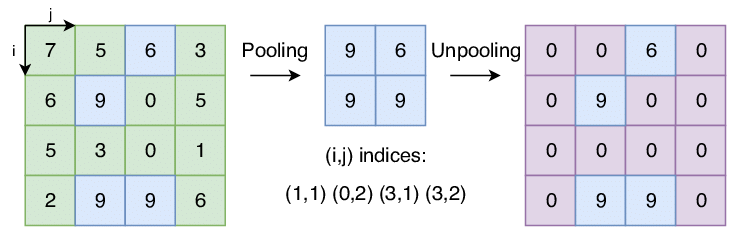

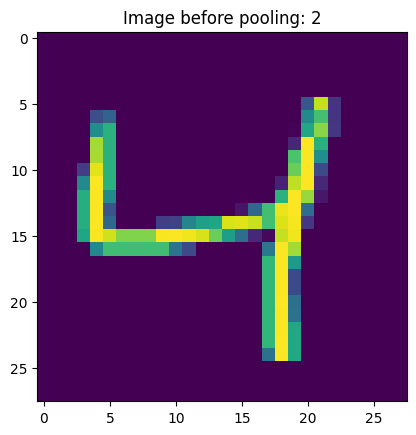

In [52]:
to_pooling_image_index = 2
to_pooling_image = reshaped_gray_train_images[to_pooling_image_index]

pooling_kernel_dim = (3, 3)
pooling_stride = 2

max_pooling_layer = LayerMaxPooling2D(pooling_kernel_dim, pooling_stride)

max_pooling_layer.forward([to_pooling_image])

plt.title(f'Image before pooling: {to_pooling_image_index}')
plt.imshow(to_pooling_image)

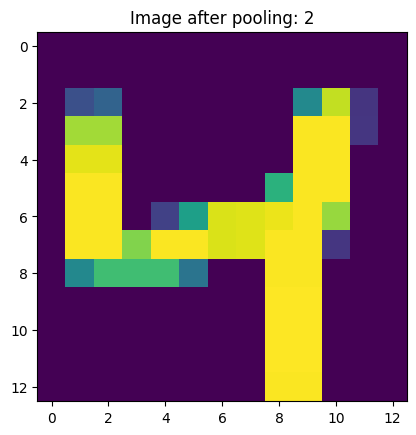

In [53]:
plt.title(f'Image after pooling: {to_pooling_image_index}')
max_pooling_output = max_pooling_layer.output[0]
plt.imshow(max_pooling_output)

In [54]:
width, height, channels = to_pooling_image.shape
kernel_width, kernel_height = pooling_kernel_dim

In [55]:
np.array(max_pooling_layer.indexes).shape

(169, 1, 3)

In [56]:
max_pooling_layer.indexes[0][0]

(0, 0, 0)

In [57]:
count = 0

unpooling_matrix = np.zeros_like(to_pooling_image)

def on_slice(x, indexes, matrix):
    global count
    slice_i = indexes['slice_i']
    slice_j = indexes['slice_j']
    slice_flat_index = indexes['slice_flat_index']

    # maximum slice_flat_index should be the same as the max_pooling_layer.output x*y or len(max_pooling_layer.indexes)

    # here we have array of max indexes for each channel [channel0: (x,y, 0), channel1: (x,y, 1), ...]
    won_elements_indexes_per_chanel = max_pooling_layer.indexes[slice_flat_index]

    # channel0: (x, y, 0), channel1: (x,y, 1), ...
    for won_element_indexes in won_elements_indexes_per_chanel:
        chanel_index = won_element_indexes[-1]

        x[
            won_element_indexes
        ] = max_pooling_output[slice_i, slice_j][chanel_index]

    return x

foreach_matrix(
    unpooling_matrix,
    on_slice,
    pooling_kernel_dim,
    pooling_stride
)

print(count, to_pooling_image.shape, np.array(unpooling_matrix).shape)

# plt.imshow(unpooling_matrix)

0 (28, 28, 1) (28, 28, 1)


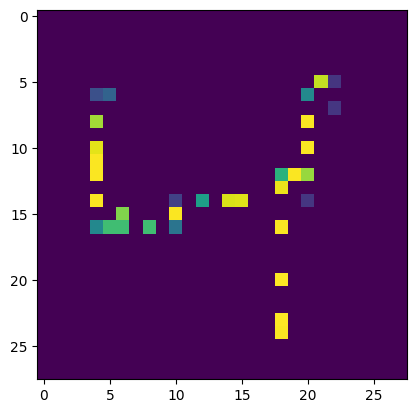

In [58]:
plt.imshow(unpooling_matrix)

# Forward pass example 

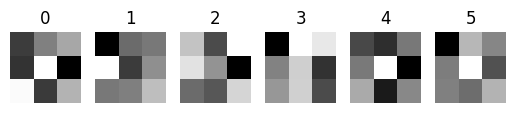

(1, 5808)

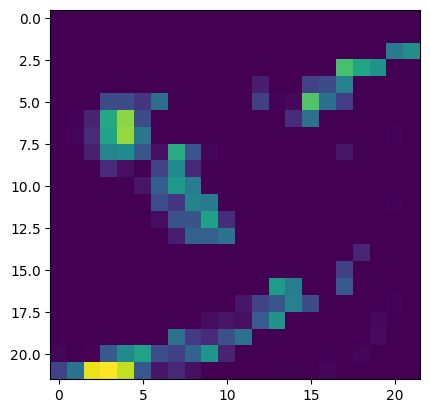

In [33]:
# 1 layer
# almost done, just verify whether we should all images passed to conv? and what about if we pass multiple images for batch training?
layer_0_filters = 6
image_channels = 1
layer_0 = LayerConv2D(
    filters_count = layer_0_filters,
    filter_dim=(3, 3),
    stride=1,
    channels=image_channels
)
layer_output_0 = layer_0.forward(reshaped_gray_train_images[:1])

layer_1 = LayerMaxPooling2D((2, 2))
layer_output_1 = layer_1.forward(layer_output_0)

# 2 layer
layer_2 = LayerConv2D(
    filters_count=12,
    filter_dim=(4, 4),
    stride=1,
    channels= image_channels * layer_0_filters
)
layer_output_2 = layer_2.forward(layer_output_1)
layer_output_3 = LayerFlatten().forward(layer_output_2)

# print(np.array(output).shape)
plot_images(layer_0.weights)
 
plt.imshow(np.array(layer_output_2)[0, :, :, 5:6]) # image 0, all width, all height, 5th channel == filters' index
layer_output_3.shape

In [34]:
# total_images = layer_output_1.shape[0]

# layer_output_1.shape, layer_output_1.reshape(total_images, -1).shape, LayerFlatten().forward(layer_output_1).shape

C:\Users\ferra\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


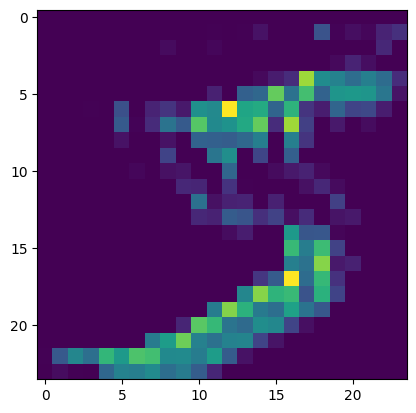

In [35]:
import tensorflow as tf

tf_conv_layer = tf.keras.layers.Conv2D(7, (5, 5), activation='relu', input_shape=(28, 28, 1), strides=1)
# forward
tf_conv_layer_output = tf_conv_layer(np.expand_dims(train_images[0:50], -1)).numpy()

plt.imshow(tf_conv_layer_output[0, :, :, 3])


In [36]:
import pandas as pd
from termcolor import colored
pd.set_option('display.expand_frame_repr', False)

def print_selected_element(data, index, selected_index):
    # Convert data into a DataFrame
    df = pd.DataFrame(data, index=index, dtype='str')
    
    # Create an output with colored column
    output = []
    for row in df.itertuples():
        colored_row = []
        for i, value in enumerate(row[1:]):  # Exclude index
            if i == selected_index:
                colored_row.append(colored(str(value), 'green'))  # Apply color to the selected column
            else:
                colored_row.append(colored(str(value), 'blue'))
                
        output.append(colored_row)
    
    # Rebuild and display the colored DataFrame
    formatted_output = pd.DataFrame(output, columns=df.columns, index=df.index)
    print(formatted_output.to_string(index=True, header=False))

# Example usage
data = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
index = ['A', 'B', 'C']
selected_index = 1
print_selected_element(data, index, selected_index)


A  1  2  3
B  4  5  6
C  7  8  9


In [37]:
import time

class LayerDense:
    @staticmethod
    def relu(x):
        return np.maximum(0, x)
    
    @staticmethod
    def sigmoid(x):
        x = np.clip(x, -500, 500)
                
        return 1 / (1 + np.exp(-x))
    
    @staticmethod
    def heaviside(x):
        return np.heaviside(x, 0)
    
    @staticmethod
    def softmax(x):
        exp_values = np.exp(x - np.max(x, axis=1, keepdims=True))
        probs = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        return probs
    
    
    def df_activation(self):
        """
            activated_output -> aL = σ(zL)
            the forward should be called before this method
        """
        activated_output = self.output

        if self.activation == LayerDense.sigmoid:
            return activated_output * (1 - activated_output)
        elif self.activation == LayerDense.relu:
            return np.where(activated_output <= 0, 0, 1)
        elif self.activation == LayerDense.softmax:
            batch_size = activated_output.shape[0]
            # Initialize the tensor for storing the derivatives
            d_softmax = np.zeros((batch_size, activated_output.shape[1], activated_output.shape[1]))
            for i in range(batch_size):
                s = activated_output[i].reshape(-1, 1)
                d_softmax[i] = np.diagflat(s) - np.dot(s, s.T)

            return d_softmax

    def set_inputs_len(self, inputs):
        self.inputs_len = inputs.shape[1]

    def init_weights(self):
        #  Kaiming initialization
        self.weights = np.random.randn(self.inputs_len, self.neurons_len) * np.sqrt(2. / self.inputs_len)

    def init_biases(self):
        self.biases = np.zeros(self.neurons_len)

    def __init__(self, neurons_len, activation=relu):
        self.inputs_len = None
        self.neurons_len = neurons_len
        self.activation = activation
        # self.init_weights()
        self.init_biases()

    def forward(self, inputs):
        if (self.inputs_len is None):
            self.set_inputs_len(inputs)
            self.init_weights()

        self.output = self.activation(np.dot(inputs, self.weights) + self.biases)

        return self.output


class NeuralNetwork:
    @staticmethod
    def load(path) -> 'NeuralNetwork':
        with open(path, 'rb') as f:
            return pickle.load(f)

    def save(self, name, folder=''):
        hyperparameters = f'{self.learning_rate}_{self.epochs}_{self.batch_size}_{self.train_size}'
        filename = name + '_' + hyperparameters + '.pkl'
        path = os.path.join(folder, filename)

        with open(path, 'wb') as f:
            pickle.dump(self, f)

    @staticmethod
    def loss_mse(y_true, y_pred):
        return np.mean((y_true - y_pred)**2)
    
    @staticmethod
    def df_loss_mse(y_true, y_pred):
        return y_pred - y_true
    
    @staticmethod
    def loss_binary_crossentropy(y_true, y_pred):
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)

        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    
    @staticmethod
    def loss_categorical_crossentropy(y_true, y_pred):
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
    
        loss = -np.sum(y_true * np.log(y_pred)) / y_true.shape[0]
        return loss

    def __init__(self, loss=loss_mse, log=True):
        self.log = log
        self.loss = loss
        self.history_accuracy = []
        self.history_loss = []
        self.history_val_accuracy = []
        self.history_val_loss = []
        self.layers = []

        # hyperparameters
        self.learning_rate = 0.01
        self.epochs = 10
        self.batch_size = 10
        self.validation_split = 0.1
        self.train_size = 0

        self.epoch = 0
        self.batch_index = 0


    def add(self, layer):
        self.layers.append(layer)

    def forward(self, inputs, log=False):
        # must be refactored!!!
        inputs_shape = inputs.shape

        if (log):
            print(colored(f'Model forward pass has started with inputs shape: {inputs_shape}\n', 'green'))

        for layer, layer_index in zip(self.layers, range(len(self.layers))):
            layer.forward(inputs)
            inputs = layer.output

            if (log):
                def shapeIfNotNone(obj, attr):
                    value = getattr(obj, attr, None)

                    return value.shape if value is not None else 'None'

                all_layers_names = (['INPUT'] +
                    list(
                        map(lambda l: l.__class__.__name__, self.layers)
                    ) + 
                    [''])

                all_layers_outputs = ([inputs_shape] +
                    list(
                        map(lambda l: shapeIfNotNone(l, 'output'), self.layers)
                    ) + 
                    ["y_true.shape"])
                all_layers_weights = ([''] +
                    list(
                        map(lambda l: shapeIfNotNone(l, 'weights'), self.layers)
                    ) + 
                    [''])
                all_layers_biases = ([''] +
                    list(
                        map(lambda l: shapeIfNotNone(l, 'biases'), self.layers)
                    ) + 
                    [''])

                print_selected_element(
                    [
                        all_layers_names, 
                        all_layers_outputs,
                        all_layers_weights, 
                        all_layers_biases, 
                    ],
                    ['Name: ', 'Outputs (alpha)', 'Weights[count, w, h, depth]: ',  'Biases[depth]: '],
                    layer_index + 1
                )
                print('\n')


        return inputs
    
    def calculate_output_delta(self, layer, y_true, y_pred):
        if layer.activation == LayerDense.softmax:
            return y_pred - y_true
        if layer.activation == LayerDense.sigmoid:
            grad_loss_input = self.df_loss_mse(y_true, y_pred) # derivative of loss function = ∇aL | samples -> neurons
            activation_derivative = layer.df_activation() # derivative of sigmoid(zL) = sigmoid(zL) * (1 - sigmoid(zL)) | samples -> neurons

            return grad_loss_input * activation_derivative # δL = ∇aL * σ'(zL) | samples -> neurons

    def log_layers(self, inputs, y_true, layer_index):
        ## must be refactored!!!
        is_first_run = self.epoch == 0 and self.batch_index == 0
        is_last_layer = len(self.layers) - 1 == layer_index


        if (is_first_run):
            if (is_last_layer):
                print(colored('Model backward pass has started \n', 'yellow'))

            def shapeIfNotNone(obj, attr):
                value = getattr(obj, attr, None)

                return value.shape if value is not None else 'None'

            all_layers_names = (['INPUT'] +
                list(
                    map(lambda l: l.__class__.__name__, self.layers)
                ) + 
                [''])

            all_layers_outputs = ([inputs.shape] +
                list(
                     map(lambda l: shapeIfNotNone(l, 'output'), self.layers)
                 ) + 
                [y_true.shape])
            all_layers_weights = ([''] +
                list(
                     map(lambda l: shapeIfNotNone(l, 'weights'), self.layers)
                ) + 
                [''])
            all_layers_grad_loss_weights = ([''] +
                list(
                    map(lambda l: shapeIfNotNone(l, 'grad_loss_weights'), self.layers)
                ) + 
                [''])
            all_layers_biases = ([''] +
                list(
                     map(lambda l: shapeIfNotNone(l, 'biases'), self.layers)
                ) + 
                [''])
            all_layers_grad_loss_biases = ([''] +
                list(
                     map(lambda l: shapeIfNotNone(l, 'grad_loss_biases'), self.layers)
                ) + 
                [''])
            all_layers_deltas = ([''] +
                list(
                     map(lambda l: shapeIfNotNone(l, 'delta'), self.layers)
                ) + 
                [''])
            

            index = ['Name: ', 'Outputs (alpha)', 'Weights: ', 'Grad Loss Weights: ', 'Biases: ', 'Grad Loss Biases: ', 'Delta: ']


            print_selected_element(
                [
                    all_layers_names, 
                    all_layers_outputs,
                    all_layers_weights, 
                    all_layers_grad_loss_weights, 
                    all_layers_biases, 
                    all_layers_grad_loss_biases, 
                    all_layers_deltas, 
                ],
                index,
                layer_index + 1
            )

    def backward_auto(self, inputs, y_true, y_pred, lr, batch_size):
        layers_count = len(self.layers)

        for layer_index in reversed(range(0, layers_count)):
            prev_backward_layer = layer_index < layers_count - 1 and self.layers[layer_index + 1] or None  
            layer = self.layers[layer_index]
            next_backward_layer = layer_index > 0 and self.layers[layer_index - 1] or None

            is_output_layer = layer_index == layers_count - 1

            # is max pooling in CNN
            if isinstance(layer, LayerMaxPooling2D):
                layer.propagated_error = prev_backward_layer.propagated_error
                after_unpooling_propagated_error = []

                samples_count = layer.propagated_error.shape[0] # === batch size

                # assert layer.propagated_error.shape == layer.output.shape

                # UNPOOLING
                for sample_index in range(samples_count):
                    sample_propagated_error = layer.propagated_error[sample_index]
                    sample_next_backward_layer_output = next_backward_layer.output[sample_index]

                    sample_unpooling_propagated_error = np.zeros_like(sample_next_backward_layer_output)

                    def on_slice(x, indexes, matrix):
                        slice_i = indexes['slice_i']
                        slice_j = indexes['slice_j']
                        slice_flat_index = indexes['slice_flat_index']
                        
                        won_elements_indexes_per_chanel = layer.indexes[slice_flat_index]
              
                        for won_element_indexes in won_elements_indexes_per_chanel:
                            chanel_index = won_element_indexes[-1]

                            x[
                                won_element_indexes
                            ] = sample_next_backward_layer_output[slice_i, slice_j][chanel_index]


                    foreach_matrix(
                        sample_unpooling_propagated_error,
                        on_slice,
                        layer.filter_dim,
                        layer.stride
                    )

                    after_unpooling_propagated_error.append(sample_unpooling_propagated_error)

                layer.propagated_error = np.array(after_unpooling_propagated_error)

                assert layer.propagated_error.shape == next_backward_layer.output.shape

                self.log_layers(inputs, y_true, layer_index)
                continue

            if isinstance(layer, LayerFlatten):
                is_next_cnn_layer = isinstance(next_backward_layer, LayerMaxPooling2D) or isinstance(next_backward_layer, LayerConv2D)

                if prev_backward_layer and is_next_cnn_layer:
                    layer.propagated_error = np.dot(
                        prev_backward_layer.delta, prev_backward_layer.weights.T
                    ).reshape(
                        prev_backward_layer.delta.shape[0], *layer.input_shape
                    )

                self.log_layers(inputs, y_true, layer_index)
                continue

            if isinstance(layer, LayerConv2D):
                layer.activation_derivative = layer.df_activation()
                layer.propagated_error = prev_backward_layer.propagated_error


                if (layer.propagated_error.shape != layer.activation_derivative.shape):
                    # Step 1: Upsample propagated_error to match spatial dimensions 
                    # Compute the scale factor for each spatial dimension
                    scale_factor = (
                        1,  # Batch size remains the same
                        layer.activation_derivative.shape[1] / layer.propagated_error.shape[1],  # Height
                        layer.activation_derivative.shape[2] / layer.propagated_error.shape[2],  # Width
                        1   # Channel dimension remains the same for now
                    )

                    # Use zoom to upsample the spatial dimensions (ignoring the batch and channel dimensions)
                    upsampled_error = zoom(layer.propagated_error, scale_factor, order=1)  # order=1 for bilinear interpolation

                    to_channels = layer.activation_derivative.shape[-1] / layer.propagated_error.shape[-1]
                    layer.propagated_error = np.repeat(upsampled_error, 4, axis=-1) 

                assert layer.propagated_error.shape == layer.activation_derivative.shape

                layer.delta = layer.propagated_error * layer.activation_derivative

                next_backward_layer_output = inputs

          
                # inspect this part!!
                if next_backward_layer != None:
                    next_backward_layer_output = next_backward_layer.output

   
                batch_size, H_in, W_in, C_in = next_backward_layer_output.shape
                _, H_out, W_out, C_out = layer.delta.shape
                _, kernel_h, kernel_w, _ = layer.weights.shape
                stride = layer.stride

                layer.grad_loss_biases = np.zeros(C_out)
                layer.grad_loss_weights = np.zeros_like(layer.weights) 

                # Compute weight gradients
                for b in range(batch_size):                       # Iterate over each image in the batch
                    for h in range(H_out):                        # Iterate over spatial height of delta
                        for w in range(W_out):                    # Iterate over spatial width of delta
                            for c_out in range(C_out):            # Iterate over output channels
                                # Extract the corresponding input patch (2x2x5)
                                input_patch = next_backward_layer_output[
                                    b,                             # Batch index
                                    h * stride:h * stride + kernel_h,  # Height slice
                                    w * stride:w * stride + kernel_w,  # Width slice
                                    :
                                ]                                 # Channels slice

                                # Compute contribution to weight gradient
                                layer.grad_loss_weights[c_out] += input_patch * layer.delta[b, h, w, c_out]

                # def on_slice(x, indexes):
                #     return x

                # for sample_index in range(batch_size):
                #     output_sample = next_backward_layer_output[0]

                #     a = map_matrix(
                #         output_sample,
                #         on_slice,
                #         layer.filter_dim,
                #         layer.stride
                #     )

                #     print(np.array(a).shape, 'np.array(a).shape')


                # for f in range(num_filters):
                #     layer.grad_loss_biases[f] = np.sum(layer.delta[:, :, :, f])
                layer.grad_loss_biases = np.sum(layer.delta, axis=(0, 1, 2))


                layer.weights = layer.weights - lr * layer.grad_loss_weights / batch_size
                layer.biases = layer.biases - lr * layer.grad_loss_biases / batch_size

                self.log_layers(inputs, y_true, layer_index)
                continue


            if is_output_layer:
                # output layer
                layer.delta = self.calculate_output_delta(layer, y_true, y_pred) 
            else:

                layer.propagated_error = prev_backward_layer.delta @ prev_backward_layer.weights.T # δL * wL.T
                layer.activation_derivative = layer.df_activation() 

                layer.delta = layer.propagated_error * layer.activation_derivative


            if layer_index != 0:
                next_backward_layer_output = next_backward_layer.output.T # the problem here when after conv layer we have pooling layer: MaxPooling2D <- Conv2D
            else:
                next_backward_layer_output = inputs.T


            layer.grad_loss_weights = np.dot(next_backward_layer_output, layer.delta) # ∇wL = aL-1.T * δL | neurons -> neurons
            layer.grad_loss_biases = np.sum(layer.delta, axis=0, keepdims=True)  # ∇bL = δL | neurons -> 1

            # clip the gradients to prevent exploding gradients
            np.clip(layer.grad_loss_weights, -1, 1, out=layer.grad_loss_weights)  
            np.clip(layer.grad_loss_biases, -1, 1, out=layer.grad_loss_biases)

            layer.weights = layer.weights - lr * layer.grad_loss_weights / batch_size
            layer.biases = layer.biases - lr * layer.grad_loss_biases / batch_size

            self.log_layers(inputs, y_true, layer_index)


    def backward_manual(self, inputs, y_true, y_pred, lr, batch_size):
        output_layer = self.layers[-1]

        output_layer.delta = self.calculate_output_delta(output_layer, y_true, y_pred)

        layer_2_backward_layer_output = self.layers[-2].output.T
        output_layer.grad_loss_weights = np.dot(layer_2_backward_layer_output, output_layer.delta) # ∇wL = aL-1.T * δL | neurons -> neurons
        output_layer.grad_loss_biases = np.sum(output_layer.delta, axis=0, keepdims=True)  # ∇bL = δL | neurons -> 1

        output_layer.weights = output_layer.weights - lr * output_layer.grad_loss_weights / batch_size
        output_layer.biases = output_layer.biases - lr * output_layer.grad_loss_biases / batch_size

        # next layer
        first_FC_layer_index = -2
        first_FC_layer = self.layers[first_FC_layer_index]

        first_FC_layer.propagated_error = output_layer.delta @ output_layer.weights.T # δL * wL.T
        first_FC_layer.activation_derivative = first_FC_layer.df_activation() 
        
        first_FC_layer.delta = first_FC_layer.propagated_error * first_FC_layer.activation_derivative

        # if it is the last layer for backward we wil take inputs.T 
        flatten_backward_layer_output = self.layers[first_FC_layer_index - 1].output.T # inputs.T # inputs.T
        first_FC_layer.grad_loss_weights = np.dot(flatten_backward_layer_output, first_FC_layer.delta) # ∇wL = aL-1.T * δL | neurons -> neurons
        first_FC_layer.grad_loss_biases = np.sum(first_FC_layer.delta, axis=0, keepdims=True)  # ∇bL = δL | neurons -> 1

        first_FC_layer.weights = first_FC_layer.weights - lr * first_FC_layer.grad_loss_weights / batch_size
        first_FC_layer.biases = first_FC_layer.biases - lr * first_FC_layer.grad_loss_biases / batch_size

        # next layer flatten layer


        flatten_layer_index = first_FC_layer_index - 1
        flatten_layer = self.layers[flatten_layer_index]

        # not sure that i should reshape after dot product or saparately
        flatten_layer.propagated_error = np.dot(
            first_FC_layer.delta, first_FC_layer.weights.T
        ).reshape(
            first_FC_layer.delta.shape[0], *flatten_layer.input_shape
        ) # the number of images -> the shape of the entered to flatten layer image
        print(first_FC_layer.delta.shape[0], *flatten_layer.input_shape)
        # should reshape - first_FC_layer.propagated_error

        max_pooling_layer_index = flatten_layer_index - 1
        max_pooling_layer = self.layers[max_pooling_layer_index]

        def map_max_element_to_propagated_error(x, total_index):
            # print(x.shape, max_pooling_layer.indexes[total_index])
            pooling_picked_indexes = max_pooling_layer.indexes[total_index] # (x_i, y_i, channel_i)

            return [
                x[path] for path in pooling_picked_indexes 
            ]

        # after_pooling_propagated_error = []

        # for sample_propagated_error in flatten_layer.propagated_error:
        #     new_sample_propagated_error = map_matrix(
        #         sample_propagated_error,
        #         map_max_element_to_propagated_error,
        #         max_pooling_layer.filter_dim,
        #         max_pooling_layer.stride,
        #     )

        #     after_pooling_propagated_error.append(new_sample_propagated_error)

        # max_pooling_layer.propagated_error = np.array(after_pooling_propagated_error)
        max_pooling_layer.propagated_error = flatten_layer.propagated_error


        # fix max pooling layer save maximum indexes and extract them from the propagated error
        # write some console logs to understand which indexes coresponed to which thing
        # at the end test perfomance by measuring time


        # next layer conv2d layer
        conv2d_layer_index = max_pooling_layer_index - 1
        conv2d_layer = self.layers[conv2d_layer_index]

        conv2d_layer.activation_derivative = conv2d_layer.df_activation()
        conv2d_layer.propagated_error = max_pooling_layer.propagated_error


        after_pooling_activation_derivative = []

        for sample_activation_derivative in conv2d_layer.activation_derivative:
            new_sample_activation_derivative = map_matrix(
                sample_activation_derivative,
                map_max_element_to_propagated_error,
                max_pooling_layer.filter_dim,
                max_pooling_layer.stride,
            )

            after_pooling_activation_derivative.append(new_sample_activation_derivative)

        conv2d_layer.activation_derivative = np.array(after_pooling_activation_derivative)



        print(conv2d_layer.propagated_error.shape, conv2d_layer.activation_derivative.shape, 'conv2d_layer.propagated_error.shape')
        
        conv2d_layer.delta = conv2d_layer.propagated_error * conv2d_layer.activation_derivative #  # (7, 13, 13, 3)
        next_backward_layer_output = inputs # (7, 28, 28, 1)

        grad_loss_weights = np.zeros_like(conv2d_layer.weights) # (3, 3, 3, 1)

        batch_size, height_out, width_out, num_filters = conv2d_layer.delta.shape
        filter_height, filter_width, input_channels, num_filters = conv2d_layer.weights.shape

        grad_loss_weights = np.zeros_like(conv2d_layer.weights)

        # Loop through each image in the batch
        for i in range(batch_size):
            for h in range(height_out):
                for w in range(width_out):
                    for f in range(num_filters):
                        input_patch = next_backward_layer_output[i, h*stride:h*stride+filter_height, w*stride:w*stride+filter_width, :]
                        
                        grad_loss_weights[:, :, :, f] += input_patch * conv2d_layer.delta[i, h, w, f]

        # Store the computed gradients
        conv2d_layer.grad_loss_weights = grad_loss_weights

        grad_loss_biases = np.zeros(num_filters)

        for f in range(num_filters):
            grad_loss_biases[f] = np.sum(conv2d_layer.delta[:, :, :, f])

        conv2d_layer.grad_loss_biases = grad_loss_biases

        conv2d_layer.weights = conv2d_layer.weights - lr * conv2d_layer.grad_loss_weights / batch_size
        conv2d_layer.biases = conv2d_layer.biases - lr * conv2d_layer.grad_loss_biases / batch_size


        # conv2d_layer.grad_loss_weights = np.dot(next_backward_layer_output, conv2d_layer.delta)


    def validation_train_split(self, inputs, y_true, validation_split, log=True):
        """
            Split the data into training and validation sets based on the validation_split percentage
            (Holdout Method)
        """

        x_val = inputs[-int(len(inputs) * validation_split):]
        y_val = y_true[-int(len(inputs) * validation_split):]
        x_true = inputs[:-int(len(inputs) * validation_split)]
        y_true = y_true[:-int(len(inputs) * validation_split)]

        if log:
            print(f'Validation set size: {len(x_val)}')
            print(f'Training set size: {len(x_true)}')


        return x_val, y_val, x_true, y_true

    def output_layer(self):
        return self.layers[-1]
    
    def accuracy(self, y_true, y_pred):
        if self.output_layer().activation == LayerDense.softmax:
            return np.mean(y_pred == y_true.argmax(axis=1))
        if self.output_layer().activation == LayerDense.sigmoid:
            return np.mean(y_true == np.round(y_pred))
        
    def evaluate(self, x, y):
        total_loss = self.loss(y, self.forward(x))
        accuracy = self.accuracy(y, self.predict(x))

        return total_loss, accuracy

    def record_history(self, x_train, y_train, x_val, y_val, epoch, epochs):
        validation_loss, validation_accuracy = self.evaluate(x_val, y_val)
        loss, accuracy = self.evaluate(x_train, y_train)

        self.history_accuracy.append(accuracy)
        self.history_loss.append(loss)
        self.history_val_accuracy.append(validation_accuracy)
        self.history_val_loss.append(validation_loss)

        if self.log:
            print(f'Evaluation set size: {len(x_train)}')
            print(f'Validation set size: {len(x_val)}')
            print(f'Epoch: {epoch+1}/{epochs} | loss {loss} | accuracy {accuracy} | validation loss {validation_loss} | validation accuracy {validation_accuracy}')
        
    def fit(self, inputs, y_true, learning_rate=0.01, epochs=10, batch_size=10, validation_split=0.1):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.validation_split = validation_split

        print(f'Total iterations {epochs * (math.ceil(len(inputs) / batch_size))}')
        print(f'Iterations of each epoch {math.ceil(len(inputs) / batch_size)}')

        x_val, y_val, x_true, y_true = self.validation_train_split(inputs, y_true, validation_split)
        self.train_size = len(x_true)

        # forwarding for logging purpose
        self.forward(x_true[0:batch_size], True)

        for epoch in range(epochs):
            self.epoch = epoch
            self.record_history(x_true, y_true, x_val, y_val, epoch, epochs)

            shuffle_indices = np.random.permutation(len(x_true))
            x_true = x_true[shuffle_indices]
            y_true = y_true[shuffle_indices]

            for i in range(0, len(x_true), batch_size):

                start_backward = time.time()

                self.batch_index = i
                inputs_batch = x_true[i:i+batch_size]
                y_true_batch = y_true[i:i+batch_size]

                y_hats = self.forward(inputs_batch) # predict the output

                self.backward_auto(
                    inputs_batch, 
                    y_true_batch, 
                    y_hats, 
                    learning_rate, 
                    batch_size
                )

                end_backward = time.time()

                print('Elapsed  time:', end_backward-start_backward)


    def reset(self):
        self.history_accuracy = []
        self.history_loss = []
        self.history_val_accuracy = []
        self.history_val_loss = []

        for layer in self.layers:
            layer.init_weights()
            layer.init_biases()

    def predict(self, inputs):
        y_hat = self.forward(inputs)

        if self.output_layer().activation == LayerDense.softmax:
            return y_hat.argmax(axis=1)
        if self.output_layer().activation == LayerDense.sigmoid:
            return np.round(y_hat)
            

In [38]:
import numpy as np
from scipy.ndimage import zoom

# Random input tensors
activation_derivative = np.random.rand(7, 14, 14, 12)
propagated_error = np.random.rand(7, 3, 3, 3)

# Step 1: Upsample propagated_error to match spatial dimensions (14x14)
# Compute the scale factor for each spatial dimension
scale_factor = (
    1,  # Batch size remains the same
    activation_derivative.shape[1] / propagated_error.shape[1],  # Height
    activation_derivative.shape[2] / propagated_error.shape[2],  # Width
    1   # Channel dimension remains the same for now
)

# Use zoom to upsample the spatial dimensions (ignoring the batch and channel dimensions)
upsampled_error = zoom(propagated_error, scale_factor, order=1)  # order=1 for bilinear interpolation
print("Shape after upsampling:", upsampled_error.shape)  # Expected: (7, 14, 14, 3)

# Step 2: Adjust channel dimensions (3 -> 12) using a linear projection
# Initialize a random weight matrix for the projection (3 input channels, 12 output channels)
projection_weights = np.random.rand(3, 12)

# Perform a channel-wise linear projection
projected_error = np.tensordot(upsampled_error, projection_weights, axes=([3], [0]))  # Project channels
print("Shape after channel projection:", projected_error.shape)  # Expected: (7, 14, 14, 12)

# Step 3: Element-wise multiplication with activation_derivative
delta_z = projected_error * activation_derivative  # Element-wise multiplication
print("Shape of delta_z:", delta_z.shape)  # Expected: (7, 14, 14, 12)


Shape after upsampling: (7, 14, 14, 3)
Shape after channel projection: (7, 14, 14, 12)
Shape of delta_z: (7, 14, 14, 12)


In [39]:
import numpy as np

input_tensor = np.random.randn(7, 14, 14, 3)

output_tensor = np.repeat(input_tensor, 4, axis=-1) 

print(output_tensor.shape)  


(7, 14, 14, 12)


In [40]:
import numpy as np

# Initialize tensors
output_next_layer = np.random.rand(7, 14, 14, 5)  # Input to the Conv2D layer
delta = np.random.rand(7, 7, 7, 4)               # Gradients from the next layer
weights = np.random.rand(4, 2, 2, 5)             # Weights (filters)
weights_gradient = np.zeros_like(weights)        # Placeholder for weight gradients

# Get shapes
batch_size, H_in, W_in, C_in = output_next_layer.shape
_, H_out, W_out, C_out = delta.shape
_, kernel_h, kernel_w, _ = weights.shape

# Stride for pooling (assumed to be 2x2)
stride = 2

# Compute weight gradients
for b in range(batch_size):                       # Iterate over each image in the batch
    for h in range(H_out):                        # Iterate over spatial height of delta
        for w in range(W_out):                    # Iterate over spatial width of delta
            for c_out in range(C_out):            # Iterate over output channels
                # Extract the corresponding input patch (2x2x5)
                input_patch = output_next_layer[
                    b,                             # Batch index
                    h * stride:h * stride + kernel_h,  # Height slice
                    w * stride:w * stride + kernel_w,  # Width slice
                    :
                ]                                 # Channels slice

                # Compute contribution to weight gradient
                weights_gradient[c_out] += input_patch * delta[b, h, w, c_out]

# Output the resulting gradients
print("Weights Gradient Shape:", weights_gradient.shape)

Weights Gradient Shape: (4, 2, 2, 5)


In [43]:
np.random.seed(0)

mlp_mnist = NeuralNetwork(loss=NeuralNetwork.loss_categorical_crossentropy)

mlp_mnist.add(LayerConv2D(filters_count=32, filter_dim=(3, 3), stride=2, activation=LayerConv2D.relu))
mlp_mnist.add(LayerMaxPooling2D((2, 2), stride=2))

mlp_mnist.add(LayerConv2D(filters_count=16, filter_dim=(2, 2), activation=LayerConv2D.relu))
mlp_mnist.add(LayerMaxPooling2D((3, 3)))

mlp_mnist.add(LayerFlatten())
mlp_mnist.add(LayerDense(16, activation=LayerDense.relu))
mlp_mnist.add(LayerDense(10, activation=LayerDense.softmax))

learning_rate = 0.01
epochs = 10
batch_size = 50
validation_split = 0.05

# issue, batch size is not fixed variates during training, why?

In [44]:
mlp_mnist.fit(reshaped_gray_train_images[0:100], train_labels[0:100], learning_rate, epochs, batch_size, validation_split)

Total iterations 20
Iterations of each epoch 2
Validation set size: 5
Training set size: 95
Model forward pass has started with inputs shape: (50, 28, 28, 1)

Name:                                    INPUT       LayerConv2D  LayerMaxPooling2D  LayerConv2D  LayerMaxPooling2D  LayerFlatten  LayerDense  LayerDense              
Outputs (alpha)                (50, 28, 28, 1)  (50, 13, 13, 32)               None         None               None          None        None        None  y_true.shape
Weights[count, w, h, depth]:                       (32, 3, 3, 1)               None         None               None          None        None        None              
Biases[depth]:                                             (32,)               None        (16,)               None          None       (16,)       (10,)              


Name:                                    INPUT       LayerConv2D  LayerMaxPooling2D  LayerConv2D  LayerMaxPooling2D  LayerFlatten  LayerDense  LayerDense              

In [414]:
np.random.rand(7, 3, 3, 12) * np.random.rand(7, 3, 3, 3)

ValueError: operands could not be broadcast together with shapes (7,3,3,12) (7,3,3,3) 

In [41]:
mlp_mnist.forward(reshaped_gray_train_images[:5]).shape

(5, 10)

In [42]:
np.random.seed(0)

cnn_mnist = NeuralNetwork(loss=NeuralNetwork.loss_categorical_crossentropy)

cnn_mnist.add(
    LayerConv2D(filters_count=2, filter_dim=(3, 3), stride=1, channels=1)
)
# weights = 2*3*3*1 = 18
# bias = 2
cnn_mnist.add(LayerMaxPooling2D((4, 4)))
cnn_mnist.add(
    LayerConv2D(filters_count=2, filter_dim=(3, 3), stride=2, channels=2)
)
cnn_mnist.add(LayerMaxPooling2D((2, 2), 2))
# weights = 3*2*2*2 = 24
# bias = 3
cnn_mnist.add(LayerFlatten())
cnn_mnist.add(LayerDense(32, activation=LayerDense.relu))
cnn_mnist.add(LayerDense(10, activation=LayerDense.softmax))

learning_rate = 0.01
epochs = 1
batch_size = 3
validation_split = 0.05

In [43]:
cnn_mnist.forward(reshaped_gray_train_images[:5]).shape

(5, 10)

In [44]:
cnn_mnist.forward(reshaped_gray_train_images[:5]).reshape(5, 10, 10, 2).shape

ValueError: cannot reshape array of size 50 into shape (5,10,10,2)

In [ ]:
cnn_mnist.layers[-3].weights.shape # 3 filters, 2x2, 2 channels

(2, 3, 3, 2)

In [ ]:
cnn_mnist.fit(reshaped_gray_train_images[0:50], train_labels[0:50], learning_rate, epochs, batch_size, validation_split)

Total iterations 17
Iterations of each epoch 17
Validation set size: 2
Training set size: 48
Evaluation set size: 48
Validation set size: 2
Epoch: 1/1 | loss 2.616778115698056 | accuracy 0.08333333333333333 | validation loss 2.734474971216127 | validation accuracy 0.0


ValueError: operands could not be broadcast together with shapes (200,32) (2,21,21,32) 